In [1]:
#!jupyter nbconvert --to=script phase_check.ipynb

last edited on February 2nd, 2019 by Claire Valva

# phase analysis: 
checks distribution of phase in fourier coefficients for each season and year

### prelims/packages

In [1]:
#import packages
import numpy as np
from scipy.signal import get_window, csd
from scipy.signal.windows import hann, hanning, nuttall, flattop
from scipy.fftpack import fft, ifft, fftfreq, fftshift, ifftshift
import matplotlib.pyplot as plt
import scipy.integrate as sciint
import pandas as pd
import datetime
import matplotlib.cm as cm
from math import pi
import matplotlib.ticker as tck
import datetime
from sympy import solve, Poly, Eq, Function, exp, re, im
from PyEMD import EMD
from netCDF4 import Dataset, num2date # This is to read .nc files and time array
from scipy.optimize import fsolve
import statsmodels.api as sm
from IPython.display import display, Markdown, Latex
import matplotlib.colors as colors
from seaborn import cubehelix_palette #for contour plot colors
import seaborn as sns
from cartopy.util import add_cyclic_point
from decimal import Decimal
import pickle
import time

In [2]:
##pickle these two to check phase later
file_Name = "phase_check_pickle"
file_pickle = open(file_Name,'rb') 
d2_trans, d2_trans_nowind = pickle.load(file_pickle)

In [3]:
##get names for later matching
file_Name = "names_seasons"
file_pickle = open(file_Name,'rb') 
names_matched, indices_matched_time = pickle.load(file_pickle)

### solve for phase from fft

In [4]:
#use these
def solve_f(X):
    #function to solve f coeff equation for trend analysis
    x,y = X
    f = Zofkt - x*np.exp(1j*y)
    return [np.real(f), np.imag(f)] 

def real_f(X):
    #function to wrap solve_f so that it can be used with fsolve
    x,y = X
    z = [x+0j,y+0j]
    actual_f = solve_f(z)
    return(actual_f)

def fwithZ(time,wavenumber, fft_zonal_result):
    global Zofkt 
    Zofkt = fft_zonal_result[time][wavenumber]
    answers = fsolve(real_f, np.array([0,0]))
    return answers

In [5]:
#get the average for each season, no windowing
d2_touse = d2_trans[0:len(d2_trans)-1]

In [6]:
#test function
start = time.time()
numbers = fwithZ(3,4, d2_touse[9]) 
end = time.time()
end - start 

0.002328157424926758

In [7]:
#get phases for a single season
start = time.time()
phase_test = [[fwithZ(freq,wave,d2_touse[0]) for wave in range(len(d2_touse[0][freq]))]
               for freq in range(len(d2_touse[0]))]
              #for array in d2_touse]
    
end = time.time()
end - start 

/home/clairev/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/home/clairev/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


48.23075842857361

In [9]:
#sets whether or not phase is computed (is not quick, so don't do unless an error)
run_fresh = False

In [10]:
if run_fresh == True:
    file = [[[fwithZ(freq,wave,array) for wave in range(len(array[freq]))]
                   for freq in range(len(array))]
                  for array in d2_touse]
    file_Name = "test_phases_removed"
    file_pickle = open(file_Name,'wb') 

    pickle.dump(file,file_pickle)
    file_pickle.close()

In [11]:
if run_fresh == False:
    file_Name = "test_phases"
    file_pickle = open(file_Name,'rb') 
    file = pickle.load(file_pickle)

In [12]:
#splits saved file apart, gets phases mod 2\pi
file = np.array(file)
phases = list(file[:,:,:,1])
amps = list(file[:,:,:,0])
phases = [entry % (2 * pi) for entry in phases]

In [13]:
seasons = ['winter', 'spring', 'summer', 'fall']

In [14]:
#sort them into each season
d2_seasons = [[phases[i] for i in range(len(d2_touse)) 
               if names_matched[i][1] == part] for part in seasons]
#sort them into each season
season_phases = [[phases[i] for i in range(len(phases)) 
               if names_matched[i][1] == part] for part in seasons]

### plot it

In [15]:
#get zonal spacing
zonal_spacing = fftfreq(240,1.5)
zonal_spacing = 1/zonal_spacing
zonal_spacing= 360 / zonal_spacing

/home/clairev/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [16]:
#do it for some sample season
number_seasons = int(len(phases)/4) - 1
sample_season = [phases[i*4] for i in range(number_seasons)]

#### sample plots for testing

<Figure size 432x288 with 0 Axes>

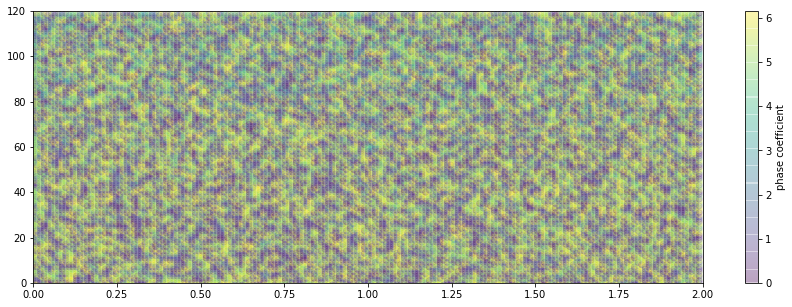

In [17]:
sample_data = sample_season[0]

plt.clf()
plt.figure(figsize=(15, 5));
frequencies = fftfreq(len(sample_data[0]), 0.25)

for i in range(len(frequencies)):
    plt.scatter(x = [frequencies[i]]*240, y = zonal_spacing, c = np.array(sample_data)[:,i], alpha = 0.2)

plt.colorbar(label = "phase coefficient")
plt.xlim((0,2))
plt.ylim((0,120))
plt.show()

<Figure size 432x288 with 0 Axes>

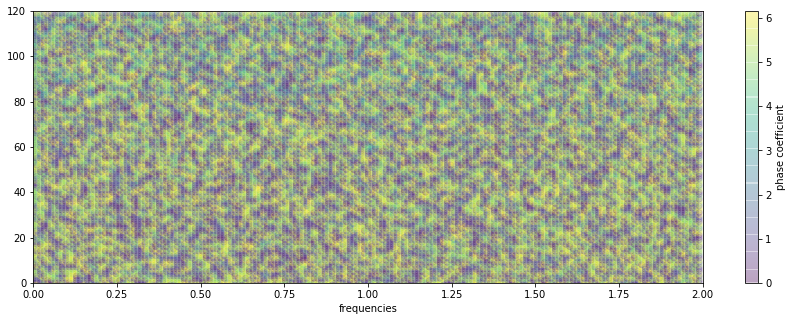

In [18]:
mod_sample_data = sample_data % (2 * pi)

plt.clf()
plt.figure(figsize=(15, 5));
frequencies = fftfreq(len(sample_data[0]), 0.25)

for i in range(len(frequencies)):
    plt.scatter(x = [frequencies[i]]*240, y = zonal_spacing, c = np.array(mod_sample_data)[:,i], alpha = 0.2)

plt.colorbar(label = "phase coefficient")
plt.xlim((0,2))
plt.ylim((0,120))
plt.xlabel("frequencies")
plt.show()

In [19]:
#quick check that I actually know what mod math is
np.exp(mod_sample_data[9][0]*1j) == np.exp(sample_data[9][0]*1j)

True

# Implement Plots

In [65]:
season_mod = [[entry % (2 * pi) for entry in season] for season in season_phases]

In [92]:
def phase_plot(data, j):
    plt.clf()
    plt.figure(figsize=(15, 5));
    frequencies = fftfreq(len(data[0]), 0.25)
    
    for i in range(len(frequencies)):
        plt.scatter(x = [frequencies[i]]*240, y = zonal_spacing, c = np.array(data)[:,i], alpha = 0.2)
        
    plt.colorbar(label = "phase coefficient")
    plt.xlim((0,2))
    plt.ylim((0,120))
    plt.xlabel(("Frequency (per day)"))
    plt.ylabel("Wavenumber")
    plt.title("phase for " + str(names_matched[j][1]) + " of " + str(names_matched[j][0]))
    
    name = "phase_plots/phase_"+ str(names_matched[j][1]) + "_" + str(names_matched[j][0]) + ".png"
    
    plt.savefig(name, bbox_inches = "tight")
    #plt.show()